In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
import pickle
from jax import jit
import jax.random as random
rng = random.PRNGKey(2022)
import jax.example_libraries.optimizers as optimizers
from jax.flatten_util import ravel_pytree

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
cm = sns.color_palette("mako_r", as_cmap=True)
from scipy.stats import gaussian_kde
from scipy.stats import gamma, lognorm
import pandas as pd

from utils_node import init_params, init_params_aniso, NODE_model, NODE_model_aniso
from utils import train_jp, eval_Cauchy, eval_Cauchy_aniso_vmap, merge_weights_aniso
from utils_diffusion import *

In [2]:
# Load the data
murine_data = pd.read_csv('data/murine_data.csv')
J = np.max(np.unique(murine_data.ID))

# Reduce the number of data points by prioritizing higher stretches
np.random.seed(2023)
def reduce_rows(df, stretch_column_1, stretch_column_2, keep_ratio):
    df_sorted = df.sort_values([stretch_column_1, stretch_column_2])
    num_rows = len(df_sorted)
    indices_to_keep = [df_sorted.index[0]] #Always keep the first point
    for i, row in df_sorted.iterrows():
        stretch_1 = row[stretch_column_1]
        stretch_2 = row[stretch_column_2]
        keep_prob = np.exp(keep_ratio * (stretch_1 + stretch_2 - 2.0))-1.0
        if np.random.uniform() < keep_prob:
            indices_to_keep.append(i)
    return df.loc[indices_to_keep]

keep_ratio = 1.2
murine_data = murine_data.groupby(['ID', 'test']).apply(reduce_rows, 'lm11', 'lm22', keep_ratio).reset_index(drop=True)

lamb_sigma_m = murine_data[['lm11', 'lm22', 'sigma11 (MPa)', 'sigma22 (MPa)']].to_numpy()
lamb_sigma_m = lamb_sigma_m[::10] #Reduce the number of points to help with training

In [3]:
n_neurons = 5

In [4]:
# Define the loss function for when training all params
@jit
def loss_sig_all(params, lamb_sigma):
    model   = NODE_model_aniso(params)
    lambx   = lamb_sigma[:,0]
    lamby   = lamb_sigma[:,1]
    sigmax  = lamb_sigma[:,2]
    sigmay  = lamb_sigma[:,3]
    sigx,sigy = eval_Cauchy_aniso_vmap(lambx,lamby, model)
    return np.mean((sigx-sigmax)**2+(sigy-sigmay)**2)

# Initialize NODEs and the optimizer
key = random.PRNGKey(0)
common_layers = [1, n_neurons, n_neurons]
sample_layers = [n_neurons,1]
params_all = init_params_aniso(common_layers, sample_layers, key)
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(params_all)

# Train
params_all, train_loss, val_loss = train_jp(loss_sig_all, lamb_sigma_m, get_params, opt_update, opt_state, key, nIter = 50000, print_freq=10000)
with open('params/mice_node_m_width_'+str(n_neurons)+'.npy', 'wb') as f:
    pickle.dump(params_all, f)

it 10000, train loss = 2.018006e-03
it 20000, train loss = 1.674565e-03
it 30000, train loss = 1.406464e-03
it 40000, train loss = 1.402733e-03
it 50000, train loss = 1.402493e-03


In [5]:
with open('params/mice_node_m_width_'+str(n_neurons)+'.npy', 'rb') as f:
    params_all = pickle.load(f)

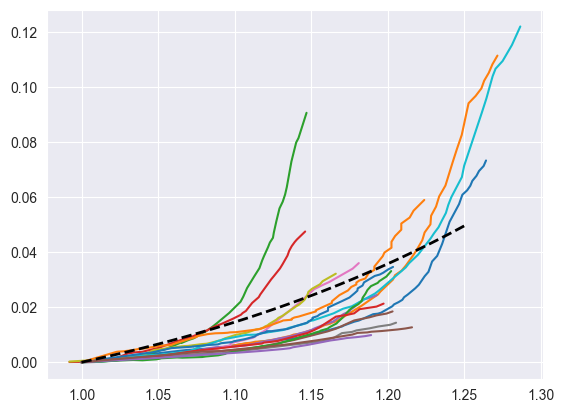

In [6]:
# Plot all the equibiaxial data
for i in np.unique(murine_data.ID):
    data_i = murine_data[(murine_data.ID==i)&(murine_data.test==2)]
    plt.plot(data_i.lm11, data_i['sigma11 (MPa)'])

# Plot model predictions
lmb = np.linspace(1,1.25)
mymodel = NODE_model_aniso(params_all)
sgmx,sgmy = eval_Cauchy_aniso_vmap(lmb,lmb, mymodel)
plt.plot(lmb, sgmx, 'k--', linewidth=2)

In [7]:
# fit individually 
NODE_weights, theta, Psi1_bias, Psi2_bias, alpha = params_all
params_I1, params_I2, params_1_v, params_1_w, params_v_w = NODE_weights
params_I1c,params_I1s = params_I1
params_I2c,params_I2s = params_I2
params_1_vc,params_1_vs = params_1_v
params_1_wc,params_1_ws = params_1_w
params_v_wc,params_v_ws = params_v_w

def loss_sample(sample_params, X): #This keeps the common params constant and varies sample_params
    params = merge_weights_aniso(params_all, sample_params)
    return loss_sig_all(params, X)

mean_sample_params = (params_I1s, params_I2s, params_1_vs, params_1_ws, params_v_ws, theta, Psi1_bias, Psi2_bias, alpha)

Sample_params = []

for j in range(J):
    lamb_sigma_j = murine_data[murine_data.ID==j][['lm11', 'lm22', 'sigma11 (MPa)', 'sigma22 (MPa)']].to_numpy()
    opt_init, opt_update, get_params = optimizers.adam(5.0e-4) # Previously 5.0e-4
    opt_state = opt_init(mean_sample_params)

    sample_params, train_loss, val_loss = train_jp(loss_sample, lamb_sigma_j, get_params, opt_update, opt_state, key, nIter = 40000, print_freq=10000)
    Sample_params.append(sample_params)

with open('params/mice_node_s_width_'+str(n_neurons)+'.npy', 'wb') as f:
    pickle.dump(Sample_params, f)

it 1000, train loss = 1.108756e-04
it 2000, train loss = 4.581037e-05
it 3000, train loss = 3.002182e-05
it 4000, train loss = 2.525826e-05
it 5000, train loss = 2.342431e-05
it 6000, train loss = 2.229433e-05
it 7000, train loss = 2.150747e-05
it 8000, train loss = 2.094455e-05
it 9000, train loss = 2.053713e-05
it 10000, train loss = 2.024028e-05
it 11000, train loss = 2.002298e-05
it 12000, train loss = 1.986329e-05
it 13000, train loss = 1.974552e-05
it 14000, train loss = 1.965832e-05
it 15000, train loss = 1.959345e-05
it 16000, train loss = 1.954500e-05
it 17000, train loss = 1.950861e-05
it 18000, train loss = 1.948117e-05
it 19000, train loss = 1.946031e-05
it 20000, train loss = 1.944428e-05
it 21000, train loss = 1.943181e-05
it 22000, train loss = 1.942194e-05
it 23000, train loss = 1.941398e-05
it 24000, train loss = 1.940742e-05
it 25000, train loss = 1.940190e-05
it 26000, train loss = 1.939716e-05
it 27000, train loss = 1.939298e-05
it 28000, train loss = 1.938923e-05
i

In [8]:
with open('params/mice_node_s_width_'+str(n_neurons)+'.npy', 'rb') as f:
    Sample_params = pickle.load(f)

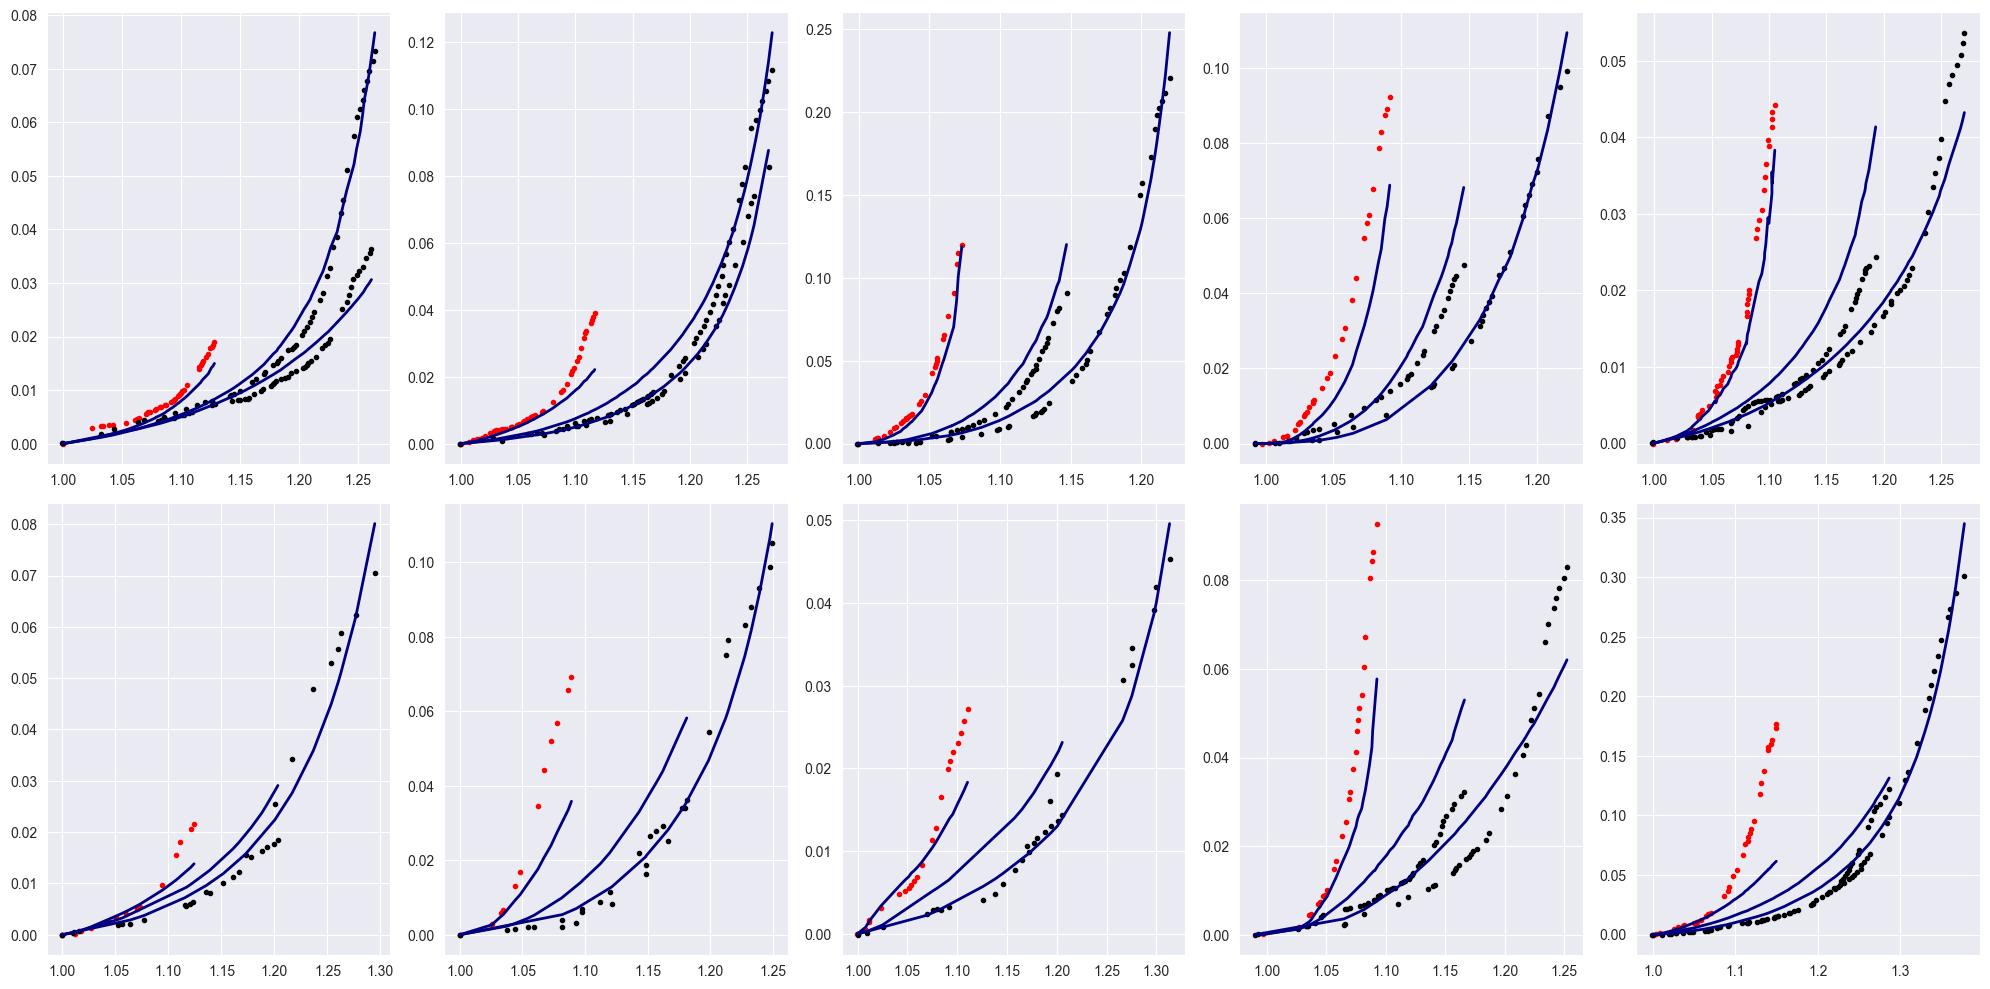

In [9]:
plt.figure(figsize = (20,10))
for i, sample_params in enumerate(Sample_params[:10]): #plot the first 10
    plt.subplot(2,5,i+1)

    data_i_offx = murine_data[(murine_data.ID==i)&(murine_data.test==0)]
    data_i_offy = murine_data[(murine_data.ID==i)&(murine_data.test==1)]
    data_i_equi = murine_data[(murine_data.ID==i)&(murine_data.test==2)]
    plt.plot(data_i_offx['lm11'], data_i_offx['sigma11 (MPa)'], 'r.',linewidth=2)
    plt.plot(data_i_offy['lm11'], data_i_offy['sigma11 (MPa)'], 'k.',linewidth=2)
    plt.plot(data_i_equi['lm11'], data_i_equi['sigma11 (MPa)'], 'k.',linewidth=2)

    params = merge_weights_aniso(params_all, sample_params)
    mymodel = NODE_model_aniso(params)
    sigx_offx,sigy_offx = eval_Cauchy_aniso_vmap(data_i_offx['lm11'].to_numpy(),data_i_offx['lm22'].to_numpy(), mymodel)
    sigx_offy,sigy_offy = eval_Cauchy_aniso_vmap(data_i_offy['lm11'].to_numpy(),data_i_offy['lm22'].to_numpy(), mymodel)
    sigx_equi,sigy_equi = eval_Cauchy_aniso_vmap(data_i_equi['lm11'].to_numpy(),data_i_equi['lm22'].to_numpy(), mymodel)
    plt.plot(data_i_offx['lm11'], sigx_offx, color='navy', linewidth=2)
    plt.plot(data_i_offy['lm11'], sigx_offy, color='navy', linewidth=2)
    plt.plot(data_i_equi['lm11'], sigx_equi, color='navy', linewidth=2)

plt.tight_layout()

In [10]:
# These are repeated stuff and loading of the above ^ data in case you need to start right with the diffusion
with open('params/mice_node_m_width_'+str(n_neurons)+'.npy', 'rb') as f:
    params_all = pickle.load(f)
with open('params/mice_node_s_width_'+str(n_neurons)+'.npy', 'rb') as f:
    Sample_params = pickle.load(f)

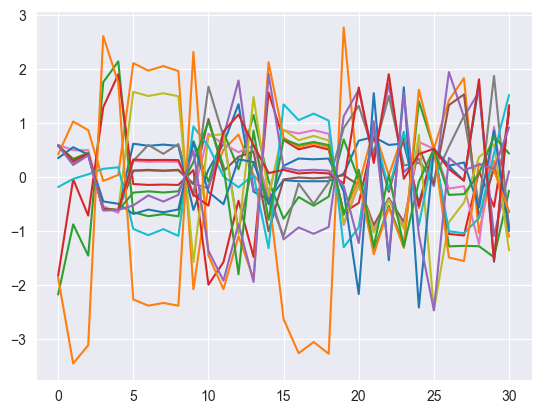

In [11]:
w_diffusion = np.array([ravel_pytree(sample_params)[0] for sample_params in Sample_params])
unravel_params = ravel_pytree(Sample_params[0])[1]

mu_x  = jnp.mean(w_diffusion,0)
std_x = jnp.std (w_diffusion,0)
w_diffusion_scaled = (w_diffusion-mu_x)/std_x

for l in w_diffusion_scaled:
    plt.plot(l)


with open('params/mice_std_x_width_' + str(n_neurons) + '.npy', 'wb') as f:
    pickle.dump(std_x, f)
with open('params/mice_mu_x_width_' + str(n_neurons) + '.npy', 'wb') as f:
    pickle.dump(mu_x, f)

In [12]:
w_diffusion_scaled = w_diffusion_scaled[:14] # need to save one for validation

#### Diffusion

Epoch 0 	, Loss 1.027037 
Epoch 1000 	, Loss 0.360840 
Epoch 2000 	, Loss 0.438230 
Epoch 3000 	, Loss 0.428701 
Epoch 4000 	, Loss 0.316662 


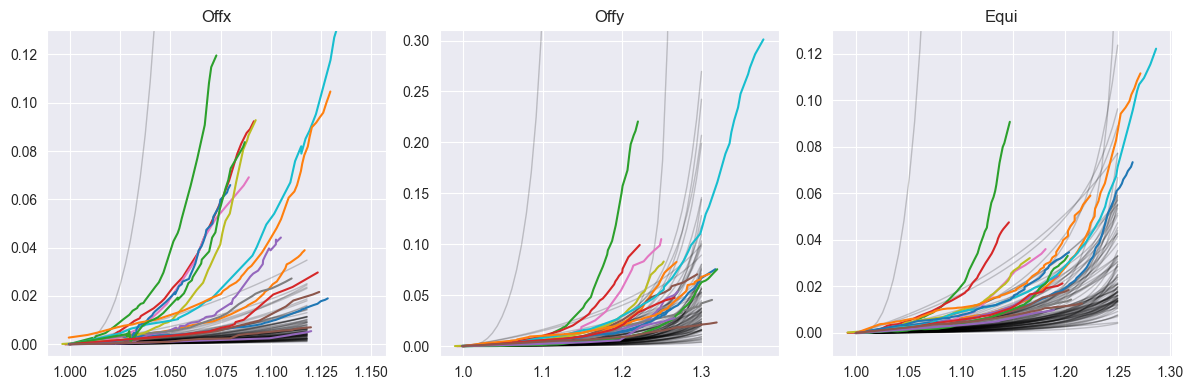

In [13]:
batch_size = 16
#some dummy input data. Flax is able to infer all the dimensions of the weights
#if we supply if with the kind of input data it has to expect
x = jnp.zeros((w_diffusion_scaled.shape[1])*batch_size).reshape((batch_size, w_diffusion_scaled.shape[1]))
time = jnp.ones((batch_size, 1))
#initialize the model weights
score_model = ApproximateScore() # from diffusion_utils
params = score_model.init(rng, x, time) # from diffusion_utils
#Initialize the optimizer
optimizer = optax.adam(5.e-4)
opt_state = optimizer.init(params)
N_epochs = 5000
train_size = w_diffusion.shape[0]
batch_size = 20
batch_size = min(train_size, batch_size)
steps_per_epoch = train_size // batch_size

params = train_diffusion(w_diffusion_scaled, score_model, N_epochs, train_size, batch_size, steps_per_epoch, rng, params, optimizer, opt_state)
with open('params/mice_diffusion_params_width_' + str(n_neurons) + '.npy', 'wb') as f:
    pickle.dump(params, f)

# Sample using the trained params
trained_score = lambda x, t: score_model.apply(params, x, t)
rng, step_rng = random.split(rng)
samples = reverse_sde(step_rng, w_diffusion_scaled.shape[1], 100, drift, dispersion, trained_score)


# Make stress predictions and compare
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12,4))
for l in samples:
  l_unscaled = l*std_x+mu_x 
  sample_params = unravel_params(l_unscaled)

  params = merge_weights_aniso(params_all, sample_params)
  mymodel = NODE_model_aniso(params)
  lmbx = np.linspace(1,1.25) 
  sigx,sigy = eval_Cauchy_aniso_vmap(np.sqrt(lmbx),lmbx, mymodel) # Offx
  axs[0].plot(np.sqrt(lmbx), sigx, color='k',linewidth=1,alpha=0.2)

  lmbx = np.linspace(1,1.3) 
  sigx,sigy = eval_Cauchy_aniso_vmap(lmbx,np.sqrt(lmbx), mymodel) # Offy
  axs[1].plot(lmbx, sigx, color='k',linewidth=1,alpha=0.2)

  lmbx = np.linspace(1,1.25) 
  sigx,sigy = eval_Cauchy_aniso_vmap(lmbx,lmbx, mymodel) # Equibi
  axs[2].plot(lmbx, sigx, color='k',linewidth=1,alpha=0.2)

for t in range(3):
  for i in np.unique(murine_data.ID):
      data_i = murine_data[(murine_data.ID==i)&(murine_data.test==t)]
      axs[t].plot(data_i.lm11, data_i['sigma11 (MPa)'])

axs[0].set(ylim=[-0.005, 0.13], title='Offx')
axs[1].set(ylim=[ -0.01, 0.31], title='Offy')
axs[2].set(ylim=[ -0.01, 0.13], title='Equi')
plt.tight_layout()